# Проект: Принятие решений в бизнесе

**Описание проекта**

**Контекст**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

**Описание данных**

**Данные для первой части**

Файл `Hypothesis`:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл `Orders`:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл `Visitors`:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## 1.  Приоритизация гипотез

### 1.1. Загрузка данных и подготовка к анализу

In [1]:
# импортирую необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt

In [2]:
# считываю данные в переменные hypothesis, visitors, orders
try:
    hypothesis, visitors, orders = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/visitors.csv'),
        pd.read_csv('/datasets/orders.csv')
    )
except:
    hypothesis, visitors, orders = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    )

In [3]:
# первое знакомство с таблицами
pd.set_option('display.max_colwidth', None)
display(hypothesis)
display(visitors.head())
display(orders.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
# проверка на пропуски и соответстиве типу данных в таблицах
display(hypothesis.info())
display(visitors.info())
display(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

**Приведу названия столбцов в привычный вид. В столбцах с датами необходимо изменить тип данных для дальнейшей работы. Пропусков в данных нет.**

In [5]:
#столбцы перевожу в нижний регистр
hypothesis.columns = hypothesis.columns.str.lower()
visitors.columns = visitors.columns.str.lower()
orders.columns = orders.columns.str.lower()

#переименую несколько столбцов
orders = orders.rename(columns={'transactionid' : 'transaction_id', 'visitorid' : 'visitor_id'})

#изменяю тип данных в столбцах с датой
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
# проверяю данные на явные дубликаты
print('Количество дубликатов в таблице hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в таблице visitors:',visitors.duplicated().sum())
print('Количество дубликатов в таблице orders:',orders.duplicated().sum())

Количество дубликатов в таблице hypothesis: 0
Количество дубликатов в таблице visitors: 0
Количество дубликатов в таблице orders: 0


**Явные дубликаты в таблицах отсутствуют.**

**Данные готовы для дальнейшей работы.**

### 1.2. Приоритизация гипотез

**Выделим приоритетные гипотезы с помощью фреймоворков ICE и RICE.**

Фреймворк *ICE* состоит из таких компонентов:
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

Расчитывается по формуле: ICE = impact * confidence / efforts

Фреймворк *RICE* помимо компонентов из фреймворка *ICE* включает дополнительный параметр:
- Reach — скольких пользователей затронет изменение, которое вы хотите внести.

Расчитывается по формуле: RICE = (reach * impact * confidence) / efforts

In [7]:
#приоритизация гипотез на основе фреймворка ICE
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']),2 )
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [8]:
#приоритизация гипотез на основе фреймворка RICE
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**При ипользовании фреймворка ICE приоритетным являются гипотезы под индексами 8,0,7, тогда как фреймворк RICE выделяет наиболее приоритетные гипотезы под индексами 7,2,0,6. С большим отрывом выделяется гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (под индексом 7), такое смещение произошло благодаря тому, что во фреймворке RICE учитывается параметр, который определяет количество пользователей, которых затронет изменение (для этой гипотезы параметр *Reach* максимальный).**

## 2. Анализ A/B-теста

**Перед построением графиков для начала необходимо выявить пользователей, которые попали и в одну и во вторую группу и удалить их из таблицы, т.к. они будут искажать данные,ведь неизвестно какая группа и как повлияла на их решение.**

In [9]:
# создаю список из пользователей, которые есть в обеих группах
listAB = []
checkA = orders[orders['group'] == 'A']
checkB = orders[orders['group'] == 'B']
for user1 in checkA['visitor_id']:
    for user2 in checkB['visitor_id']:
        if user1 == user2:
            if user1 not in listAB:
                listAB.append(user1)
print('Количество пользователей входящих в обе группы:', len(listAB))

Количество пользователей входящих в обе группы: 58


In [10]:
# удаляю пользователей из таблицы orders, которые входят в обе группе
# сбрасываю индексу и смотрю изменения
orders = orders.query('visitor_id not in @listAB')
orders.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           1016 non-null   int64         
 1   transaction_id  1016 non-null   int64         
 2   visitor_id      1016 non-null   int64         
 3   date            1016 non-null   datetime64[ns]
 4   revenue         1016 non-null   int64         
 5   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 47.8+ KB


**После удаления пользователей входящих в обе группы тестирования, было удалено 183 строки из таблицы orders.**

**1. График кумулятивной выручки по группам**

In [11]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = (
    datesGroups.apply(
        lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                        orders['group'] == x['group'])]
        .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}),
        axis=1)
    .sort_values(by=['date','group'])
)

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = (
    datesGroups.apply(
        lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                          visitors['group'] == x['group'])]
        .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

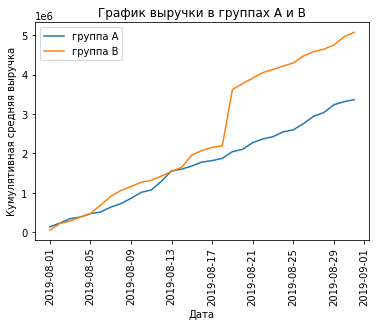

In [12]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='группа B')
plt.title('График выручки в группах А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная средняя выручка')
plt.xticks(rotation=90)
plt.legend();

**Выручка достаточно плавно увеличивается,если не считать всплесков. На графике группы B заметен очень резкий скачок, который вызван либо очень дорогим заказом, либо увеличением количества заказов в выборке в данном промежутке.**

**2. График кумулятивного среднего чека по группам**

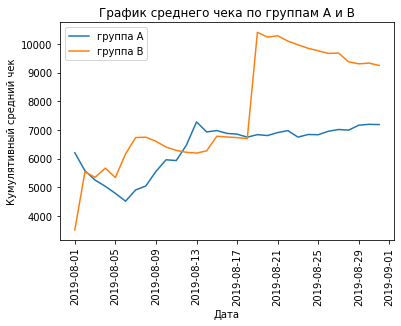

In [13]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа B')
plt.title('График среднего чека по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.xticks(rotation=90)
plt.legend();

**На графике заметны сильные колебания среднего чека вначале теста, особенно заметен резкий рост среднего чека в группе В, который вызван либо дорогим заказом, либо большим количеством заказов в этом промежутке. К концу наблюдаемого периода сумма среднего чека в группе А выравнивается, в группе В сумма среднего чека после резкого роста находится в падении.**

**3. График относительного изменения кумулятивного среднего чека группы B к группе A**

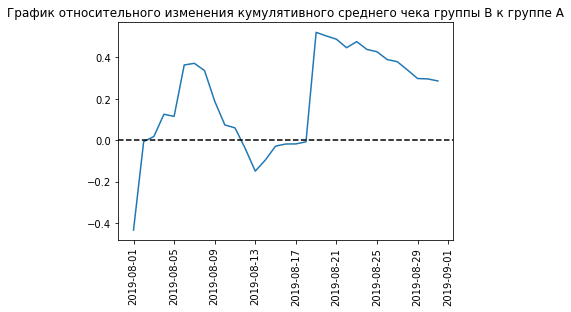

In [14]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left',
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.xticks(rotation=90)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--');

**Выбросы, крупные заказы делают волнообразный график, так же заметен резкий скачок в районе середины теста, а после спад по отношению к среднему чеку группы А.**

**4.График кумулятивного среднего количества заказов по группам**

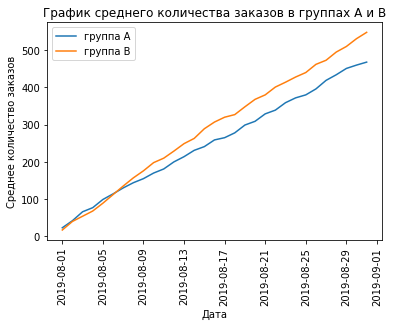

In [15]:
# Строим график кумулятивного количества заказов группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['orders'], label='группа A')

# Строим график кумулятивного количества заказов группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders'], label='группа B')
plt.title('График среднего количества заказов в группах А и В')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=90)
plt.legend();

**Количество заказов в группах А и В раномерно растет. Различие по количеству заказов в группах минимально.**

**5.График относительного изменения кумулятивного среднего количества заказов группы B к группе A**

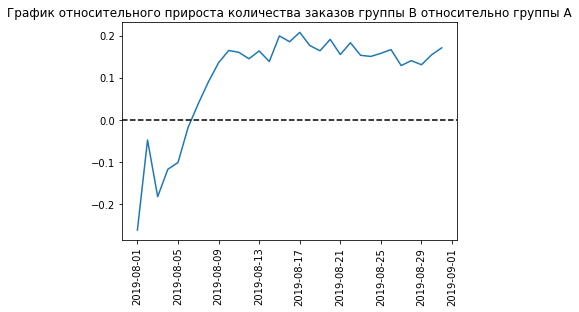

In [16]:
mergedCumulativeOrders = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                  left_on='date',
                                                  right_on='date',
                                                  how='left',
                                                  suffixes=['A', 'B'])

plt.plot(mergedCumulativeOrders['date'],
         mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['ordersA']-1,
         label="Относительный прирост количества заказов группы B относительно группы A")
plt.title('График относительного прироста количества заказов группы B относительно группы A')
plt.xticks(rotation=90)
plt.axhline(y=0, color='black', linestyle='--');

**После начальных колебаний и резкого скачка числа заказов вначале, количество заказов в группе В относительно стабилизировалось по отношению к группе А. Всплески и колебания скорее всего вызваны аномалиями, есть небольшая тенденция на спад.**

**6. Точечный график количества заказов по пользователям.**

In [17]:
# группирую пользователей по количеству сделанных заказов
countOrdersByUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
countOrdersByUsers.columns=['user_id', 'orders']
display(countOrdersByUsers.sort_values(by='orders', ascending=False).head(10))

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


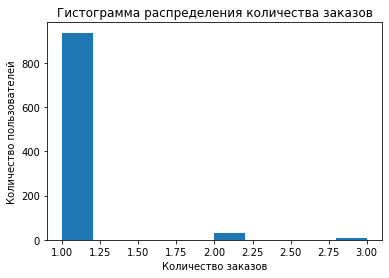

In [18]:
# построю гистограмму распределения количества заказов по пользователям
plt.title('Гистограмма распределения количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.hist(countOrdersByUsers['orders']);

**Большинство пользователей сделали не больше 2х заказов.**

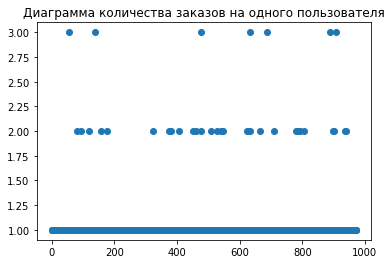

In [19]:
# строю точечный график количества заказов по пользователям
x_values = pd.Series(range(0,len(countOrdersByUsers)))
plt.title('Диаграмма количества заказов на одного пользователя')
plt.scatter(x_values, countOrdersByUsers['orders']);

**Заметны пользователи с аномальным количеством заказов, для большинства пользователей характерно не больше 2х заказов.**

**7. 95-й и 99-й перцентили количества заказов на пользователя**

In [20]:
print('95-й и 99-й перцентили количества заказов на пользователя:', np.percentile(countOrdersByUsers['orders'], [95, 99]))

95-й и 99-й перцентили количества заказов на пользователя: [1. 2.]


**Согласно данным не более 5% пользователей с заказами больше одного и не более 1% пользователей с заказами больше 2х. Пользователи с заказами больше 2х можно считать аномальными.**

**8.Точечный график стоимостей заказов**

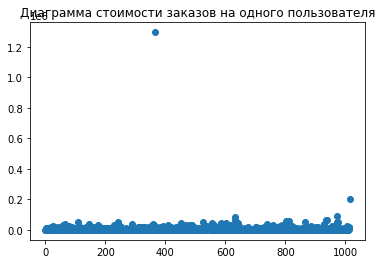

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.title('Диаграмма стоимости заказов на одного пользователя')
plt.scatter(x_values, orders['revenue']);

**На этом графике заметно одно сильно выбивающееся значение очень дорогого заказа, который и привел к резкого всплеску который был виден при оценке графиков кумулятивного среднего чека и выручки в группах. Чтобы оценить остальные выбросы сделаю срез без этой аномалии.**

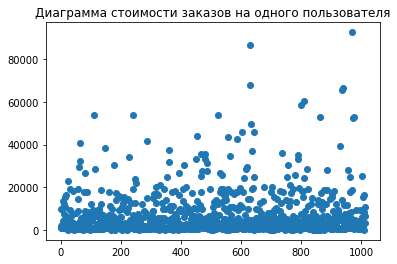

In [22]:
revenueNoAnomal=orders.query('revenue <200000')

x_values = pd.Series(range(0,len(revenueNoAnomal['revenue'])))
plt.title('Диаграмма стоимости заказов на одного пользователя')
plt.scatter(x_values, revenueNoAnomal['revenue']);

**Без аномального значения стоимость большинства заказов пользователей находится в пределах до 40000. Поэтому границу для определения пользователей с аномальной стоимостью заказов можно провести в границах от 20000 до 40000. Точнее можно будет сказать по перцентилям.**

**9. 95-й и 99-й перцентили стоимости заказов**

In [23]:
print('95-й и 99-й перцентили стоимости заказов:', np.percentile(orders['revenue'], [95, 99]))

95-й и 99-й перцентили стоимости заказов: [26785. 53904.]


**Исходя из данных,мы можем сказать, что есть не больше 5% пользователей со стоимостью заказов больше 26785 и не больше 1% пользователей со стоимостью заказов больше 53904. Пользователей со стоимостью заказа больше  26785 будут аномальными.**

**10. Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным**

В предыдущих шагах оценил данные по графикам и пришел к выводу что в данных есть значительные выбросы как в количестве заказов на одного пользователя, так и в стоимости заказа, что привело к значительным всплескам и сильно исказили результаты теста. После преварительной оценки были определены границы аномалий для количества и стоимости заказов на пользователя.

Посчитаю статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Для начала сформулирую нулевую и альтернативную гипотезы.

- Нулевая гипотеза: различий в среднем количестве заказов между группами нет.
- Альтернативная гипотеза: различия в среднем количестве заказов есть.

Для этих и последующих вычислений зададим уровень статистической значимости alpha = 0.05

In [24]:
# подготавливаю данные для анализа
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

Получаем таблицу с такими столбцами:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

In [25]:
# перехожу непосредственно к самим вычислениям различий в среднем количестве заказов между группами по "сырым" данным
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие в среднем количестве заказов между группами:',"{0:.3f}"
      .format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительное различие в среднем количестве заказов между группами: 0.160


**P-value ниже уровня статистической значисмости, значит нулевую гипотезу мы отвергаем, соответственно различия в среднем количестве заказов есть. При этом среднее количество заказов в группе В на 16% больше, чем в группе А.**

**11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным**
 - Нулевая гипотеза: различий в среднем чеке заказа между группами нет.
 - Альтернативная гипотеза: различия в среднем  чеке заказа есть.

In [26]:
# делаю расчет статистической значимости различий в среднем чеке заказа между группами
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                   orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие в среднем чеке между группами:','{0:.3f}'
      .format(orders[orders['group']=='B']['revenue']
              .mean()/orders[orders['group']=='A']['revenue']
              .mean()-1))

p-value: 0.829
Относительное различие в среднем чеке между группами: 0.287


**P-value больше уровня статистической значимости, значит различий в среднем чеке заказа между группами нет. Нулевую гипотезу не отвергаем.**

**12. Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным.** 

Для того, чтобы посчитать статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным, необходимо сначала выделить пользователей с аномальным количеством заказов и с аномальной стоимостью заказов. По рассмотренным выше данным выделил аномальных пользователей,у которых число заказов больше 2х и со стоимостью заказов больше 26785.

Нулевая и альтернативная гипотеза остаются теми же. Уровень статистической значимости тоже не изменяется alpha = 0.05.

In [27]:
# записываю переменные границами аномальных зон для пользователей
countOrdersAnomalZone = np.percentile(countOrdersByUsers['orders'], [99])
revenueAnomalZone = np.percentile(orders['revenue'], [95])

In [28]:
# выделяю аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > countOrdersAnomalZone[0]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > countOrdersAnomalZone[0]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenueAnomalZone[0]]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Количество аномальных пользователей:', abnormalUsers.shape[0])

Количество аномальных пользователей: 58


In [29]:
# делаю расчеты различий в среднем количестве заказов между группами по данным очищенным от аномалий
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('p-value:','{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие в среднем количестве заказов между группами:','{0:.3f}'
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.012
Относительное различие в среднем количестве заказов между группами: 0.182


**P-value с очищенными данными почти не изменилось, следовательно нулевую гипотезу так же отвергаем, есть различие в среднем количестве заказов между группами. После очистки данных относительное различие в среднем количестве заказов еще увеличилось приблизительно на 2%.**

**13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным**

In [30]:
# делаю расчеты статистической значимости различий в среднем чеке заказа между группами по данным очищенным от аномалий
print('p-value:',
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие в среднем чеке между группами:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.646
Относительное различие в среднем чеке между группами: -0.048


**P-value выше уровня статистической значимости. Нулевую гипотезу не отвергаем, различий в среднем чек между группами нет и с "очищенными" данными.**

**14. Выводы по результатам теста**

- Несколько аномалий (особенно в стоимости заказа) сильно искажают результаты.
- Есть статистическое различие по среднему количеству заказов между группами в данных и до очистки данных и после. Относительное различие в количестве заказов в группе B по отношению к гурппе А составляет 16% по "сырым" данным и 18% по очищенным в пользу группы В.
- Нет статистического различия в среднем чеке между группами.
- График относительного различия среднего чека показывает, что результаты группы В ухудшаются.
Исходя из полученных данных можно сделать вывод, что несмотря на большее количество заказов,средний чек при относительном различии ниже в группе В. 

**С учетом заметных тенденций на ухудшение результатов среднего чека, отсутствия предпосылок для роста количества заказов в группе В принять решение о том,чтобы остановить тест и зафиксировать победу группы А.**